# Nested sampling for a single observed spectrum

Forward modeling of a brown dwarf spectrum using modern atmospheric models and the ``dynesty`` Bayesian framework.

In [1]:
import seda # import the seda package
import importlib
import numpy as np
import pickle
from dynesty import plotting as dyplot # to plot nested sampling results
from astropy.io import fits, ascii


    SEDA package imported


Read the spectrum of interest.

As an example here, let's read the near-infrared IRTF/SpeX spectrum for the T8 (~750 K) brown dwarf 2MASS J04151954-0935066 in [Burgasser et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004AJ....127.2856B/abstract):

In [2]:
# SpeX spectrum
SpeX_name = 'data/IRTF_SpeX_0415-0935.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A

**Read input data**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.InputData).

For any SEDA function, we can also see the function description directly on the notebook with the command ``help()``, e.g.:

``help(seda.input_parameters.InputData)``

In [3]:
# input spectrum
wl_spectra = wl_SpeX
flux_spectra = flux_SpeX
eflux_spectra = eflux_SpeX
# specify flux units
flux_unit = 'erg/s/cm2/A'

# resolution of input spectrum (used to convolve the model spectra)
res = 100

# distance to the target (optional and used to derive a radius)
distance = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
edistance = 0.06 # pc

# load all the input data parameters
my_data = seda.InputData(wl_spectra=wl_spectra, flux_spectra=flux_spectra, 
                         eflux_spectra=eflux_spectra, flux_unit=flux_unit, 
                         res=res, distance=distance, edistance=edistance)


   Input data loaded successfully


Download (if not yet) the atmospheric models you want to use. 

Use the commands below to see the available atmospheric models, the links to download them, and other relevant information from models. You can read more about the model [here](https://seda.readthedocs.io/en/latest/overview.html#available-atmospheric-models).

Also consider [this tutorial](https://seda.readthedocs.io/en/latest/notebooks/tutorial_models_examination.html) to explore the free parameters in the models and their coverage.

In [4]:
# available atmospheric models
seda.Models().available_models

['BT-Settl',
 'ATMO2020',
 'Sonora_Elf_Owl',
 'SM08',
 'Sonora_Bobcat',
 'Sonora_Diamondback',
 'Sonora_Cholla',
 'LB23']

In [5]:
# some parameters of interest from a selected model
model = 'ATMO2020'
print(seda.Models(model).ref) # reference
print(seda.Models(model).ADS) # link to paper
print(seda.Models(model).download) # link to download the models
seda.Models(model).params_unique # coverage of free parameters in the grid

Phillips et al. (2020)
https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P/abstract
https://noctis.erc-atmo.eu/fsdownload/zyU96xA6o/phillips2020


{'Teff': array([ 200.,  250.,  300.,  350.,  400.,  450.,  500.,  550.,  600.,
         700.,  800.,  900., 1000., 1100., 1200., 1300., 1400., 1500.,
        1600., 1700., 1800., 1900., 2000., 2100., 2200., 2300., 2400.,
        2500., 2600., 2700., 2800., 2900., 3000.]),
 'logg': array([2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 'logKzz': array([0., 4., 6.])}

**Read model grid options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.ModelOptions).

In [6]:
# select the atmospheric models of interest
model = 'ATMO2020'

# path to the directory or directories containing the model spectra
# (update it to your own path)
my_path = '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/'
model_dir = [my_path+'CEQ_spectra/',
             my_path+'NEQ_weak_spectra/',
             my_path+'NEQ_strong_spectra/',
            ]

# set parameter ranges to select a grid subset and to be used as uniform priors
# when a free parameter range is not specified, the whole grid range will be explored
params_ranges = {
    'Teff': [700, 900], # Teff range
    'logg': [4.0, 5.0] # logg range
}

# load model options
my_model = seda.ModelOptions(model=model, model_dir=model_dir, 
                             params_ranges=params_ranges)


   Model options loaded successfully


**Tip:** If you plan to model several spectra from the same instrument (same resolution), you can save the convolved model spectra to reuse them and do subsequent fits much faster. For this, set the parameter ``path_save_spectra_conv`` in ``seda.ModelOptions`` above to a folder path where you want to store the convolved spectra. Once the spectra are stored, the next time you run the code just replace ``model_dir`` by the path you used in ``path_save_spectra_conv`` and set ``skip_convolution=True`` to avoid the model convolution. This was implemented thanks to [issue](https://github.com/suarezgenaro/seda/issues/14).

**Read Bayes fit options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.BayesOptions).

Consider the default full wavelength range of the input spectrum for the fits. Otherwise, we can use the parameter ``fit_wl_range`` to set a different fit range. 

In [7]:
# choose a filename (optional) to save the sampling results as a pickle file
# it is convenient to set a non-default name when running 
# the code several times in the same folder to avoid overwriting results
bayes_pickle_file = f'{model}_bayesian_sampling_single_spectrum.pickle'

# radius range for the sampling
R_range = np.array((0.6, 1.0)) # Rjup

# load Bayesian fit options
my_bayes = seda.BayesOptions(my_data=my_data, my_model=my_model, R_range=R_range,
                             bayes_pickle_file=bayes_pickle_file)


For input observed spectrum #1

      27 model spectra selected with:
         Teff range = [700, 900]
         logg range = [4.0, 5.0]


Reading, convolving, and resampling model grid:   0%|          | 0/27 [00:00<?, ?it/s]

      elapsed time: 0.0 s

   Bayes fit options loaded successfully


**Run nested sampling**

In [8]:
out_bayes = seda.bayes(my_bayes)


   Estimate Bayesian posteriors

      Uniform priors:
         Teff range = [700. 900.]
         logg range = [4. 5.]
         logKzz range = [0. 6.]
         R range = [0.6 1. ]

   Starting dynesty...


19526it [00:40, 482.47it/s, batch: 6 | bound: 4 | nc: 1 | ncall: 55169 | eff(%): 35.297 | loglstar: 2937.390 < 2942.785 < 2941.313 | logz: 2924.266 +/-  0.119 | stop:  0.931]            

      Bayesian sampling results saved successfully

   Bayesian sampling ran successfully
      elapsed time: 40.0 s


**Plot results**

The ``out_bayes`` output above from ``seda.bayes()`` is the input file to make plots.

If ``out_bayes`` is not in memory (if we reloaded the notebook or restarted the kernel), we need to open the pickle file first as below.

In [9]:
# open the pickle file
bayes_pickle_file = 'ATMO2020_bayesian_sampling_single_spectrum.pickle'
with open(bayes_pickle_file, 'rb') as file:
    out_bayes = pickle.load(file)

print('Posteriors loaded successfully')

Posteriors loaded successfully


Make corner plot using dynesty tools

Quantiles:
Teff [(0.025, 754.8273512113915), (0.5, 756.6585263611169), (0.975, 758.5799572618844)]
Quantiles:
logg [(0.025, 4.312417692545089), (0.5, 4.330206082234192), (0.975, 4.348592827370728)]
Quantiles:
logKzz [(0.025, 3.4466418648904584), (0.5, 3.535252017172466), (0.975, 3.6244195281777207)]
Quantiles:
R [(0.025, 0.7741200899132137), (0.5, 0.7781879409014281), (0.975, 0.7821950785698395)]


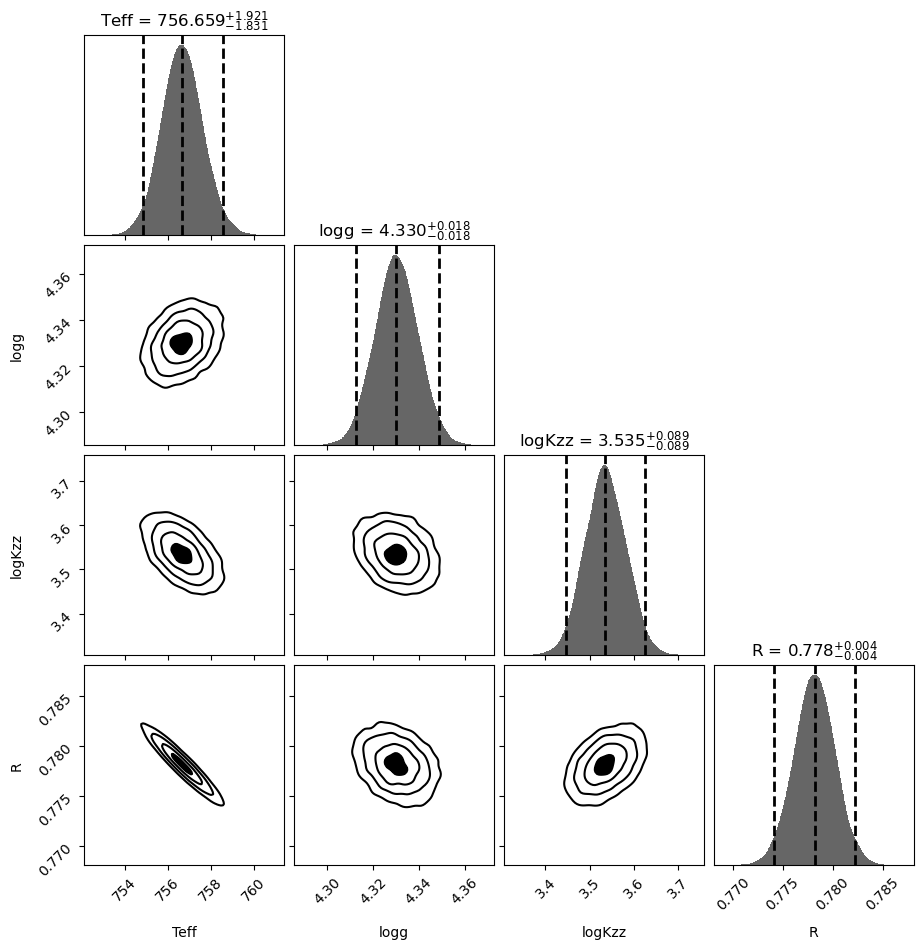

In [10]:
# plot the 2-D marginalized posteriors.
labels = list(out_bayes['my_bayes'].params_priors.keys())
fig, axes = dyplot.cornerplot(out_bayes['out_dynesty'], show_titles=True, verbose='true', 
                              title_fmt='.3f', title_kwargs={'y': 1.0}, labels=labels)

Plot a summary of the run

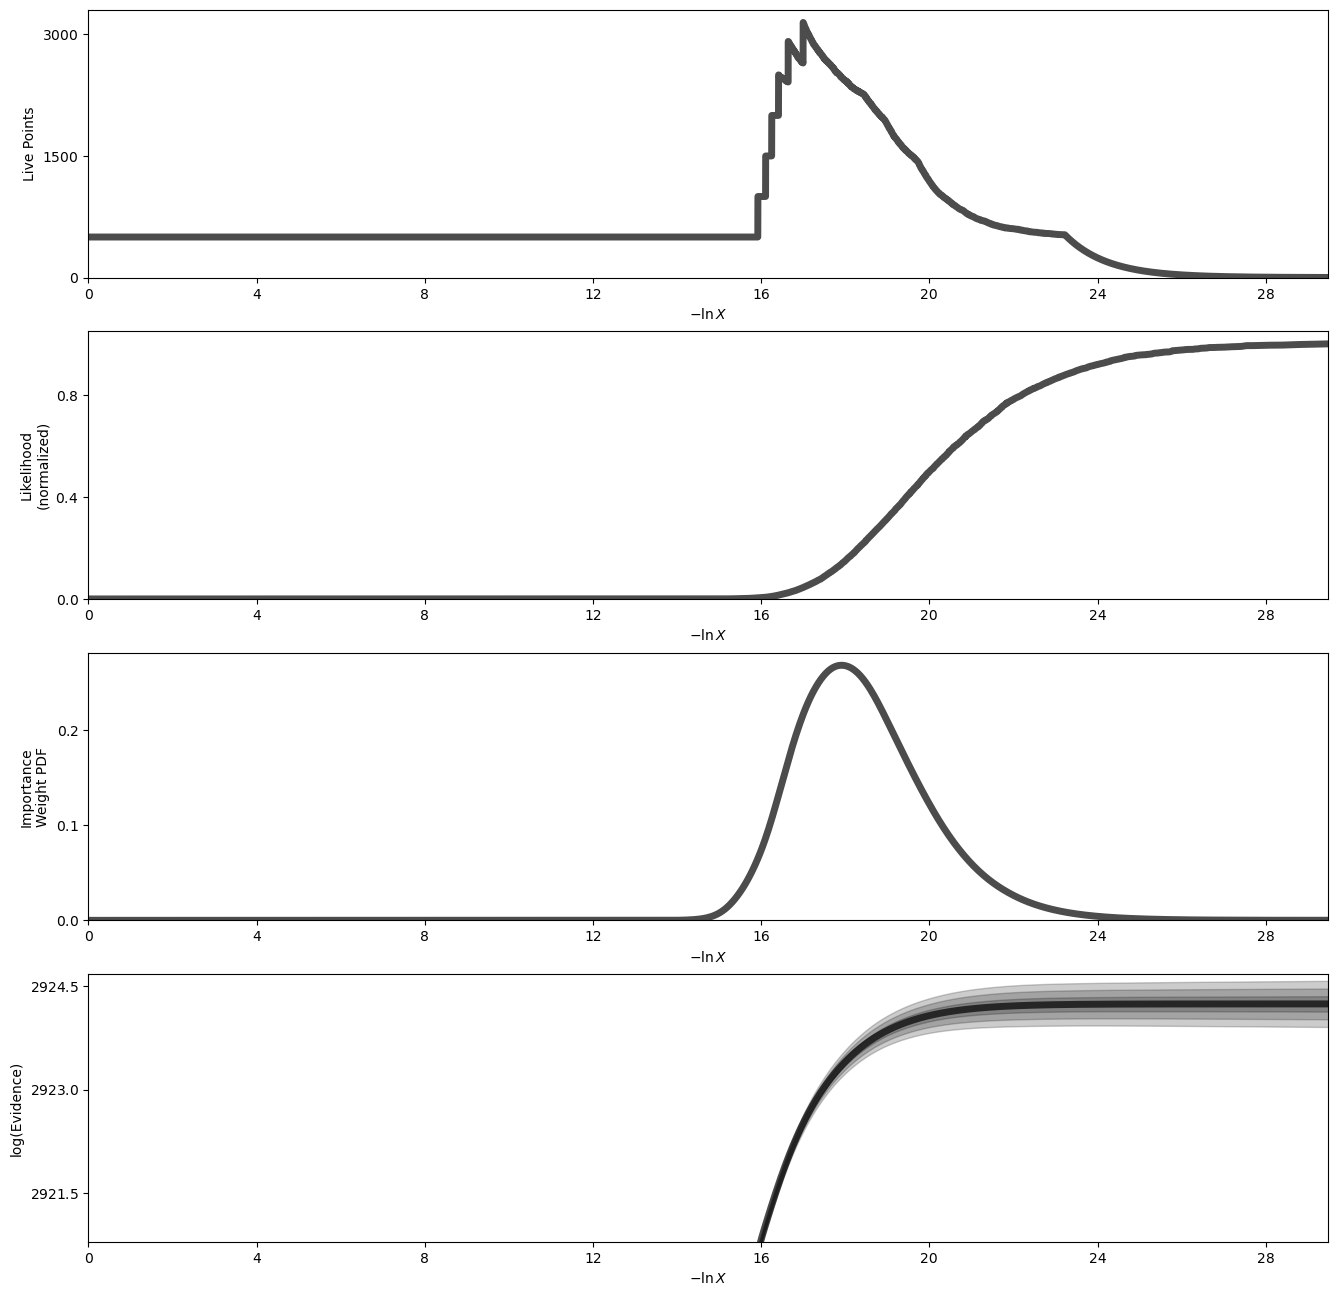

In [11]:
fig, axes = dyplot.runplot(out_bayes['out_dynesty'], color='black', mark_final_live=False, logplot=True)

Plot traces and 1-D marginalized posteriors

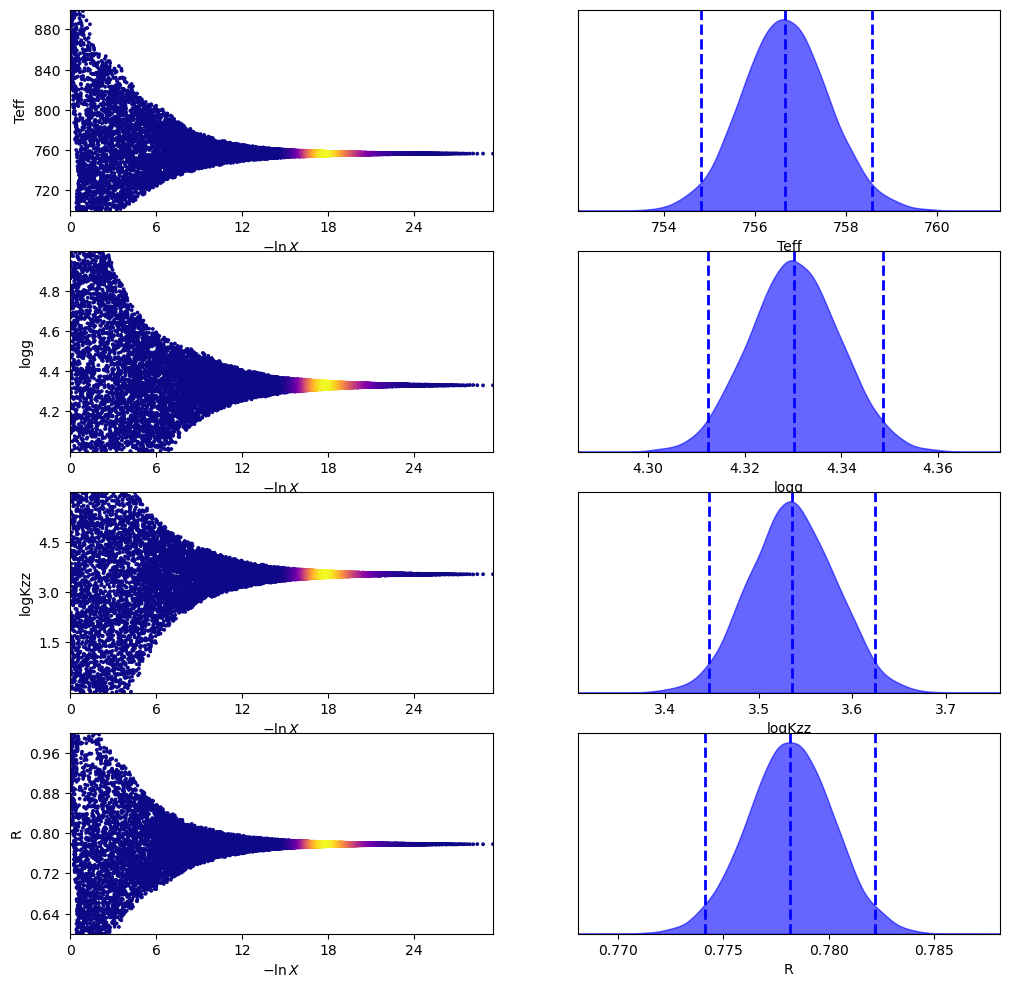

In [12]:
fig, axes = dyplot.traceplot(out_bayes['out_dynesty'], labels=labels)

**Plot the model spectrum from the median posteriors**

SED with the best model fit from the Bayesian sampling.

The pickle file generated by ``seda.bayes_fit`` and stored with the name ``my_bayes.bayes_pickle_file`` is the input file to make plots. We can provide the name by either using ``my_bayes.bayes_pickle_file`` (if the ``my bayes`` is in memory) or just typing it.

The best model fit will be generated by interpolating into a model grid subset around the median posteriors.


      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.  4.5]
         logKzz range = [0. 4.]


Reading model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s


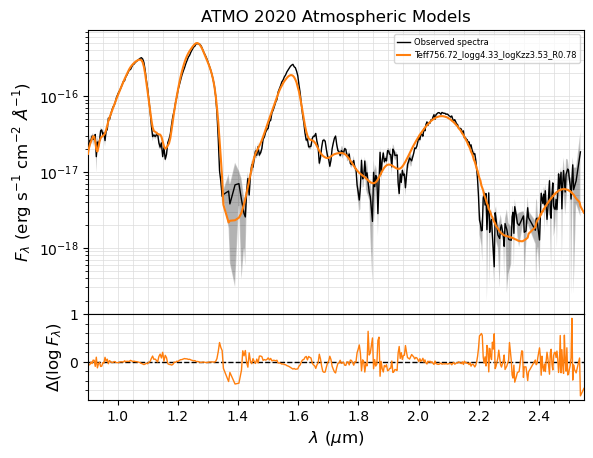

In [13]:
# using default logarithmic scale for fluxes
seda.plot_bayes_fit(bayes_pickle_file)


      32 model spectra selected with:
         Teff=[750.0, 800.0]
         logg=[4.5, 4.75]
         Z=[0.0, 0.5]
         logKzz=[2.0, 4.0]
         CtoO=[1.0, 1.5]


Reading model grid:   0%|          | 0/32 [00:00<?, ?it/s]

      elapsed time: 1.0 s


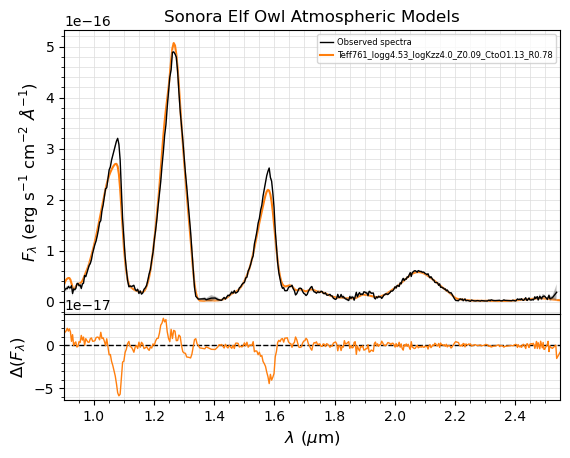

In [14]:
# considering fluxes in linear scale
seda.plot_bayes_fit(bayes_pickle_file, ylog=False)